<title>
    # A model for binary multivariate time series


<h1 align=center> A model for binary multivariate time series generation </center>

In [3]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter 
import tqdm
import math
import xarray as xr
%matplotlib inline


## Data generation mechanism

In [6]:
def sample(i :int, T :int, d :int): 
    
    """
    Data generating function. Returns A, B,sigma as matrices, the sampled data as a tensor, and the latent state
    data as a tensor. 
    """

    A = 0.3*np.identity(d) + 0.1*np.random.randn(d,d)
    B = 0.8*np.identity(d) + 0.1*np.random.randn(d,d)
    random_matrix = 0.7*np.random.randn(d,d)
    sigma = np.dot(random_matrix,random_matrix.T)
    
    x_data = np.zeros((i,d,T))
    z_data = np.zeros((i,d,T))
    #dimension 0: individus, dimension 1: features, dimension 2: temps
    
    
    #initialization 
    x = np.random.randint(0,2,size=(d,i))
    z = np.random.randn(d,i)
    x_data[:,:,0] = x.T
    z_data[:,:,0] = z.T
    
    
    for t in np.arange(1,T): 
        z = A@x + B@z + np.random.multivariate_normal(mean=np.zeros(d),cov=sigma,size=i).T
        p = stats.norm.cdf(z)
        x = np.random.binomial(1,p,size=(d,i))
        x_data[:,:,t] = x.T
        z_data[:,:,t] = z.T
        
    return A,B,sigma,x_data,z_data
        
        
        

    

    

In [7]:
T=900
d=4
A,B,sigma,test_data,z_data = sample(100,T,d)

Text(0.5, 0, 'Time')

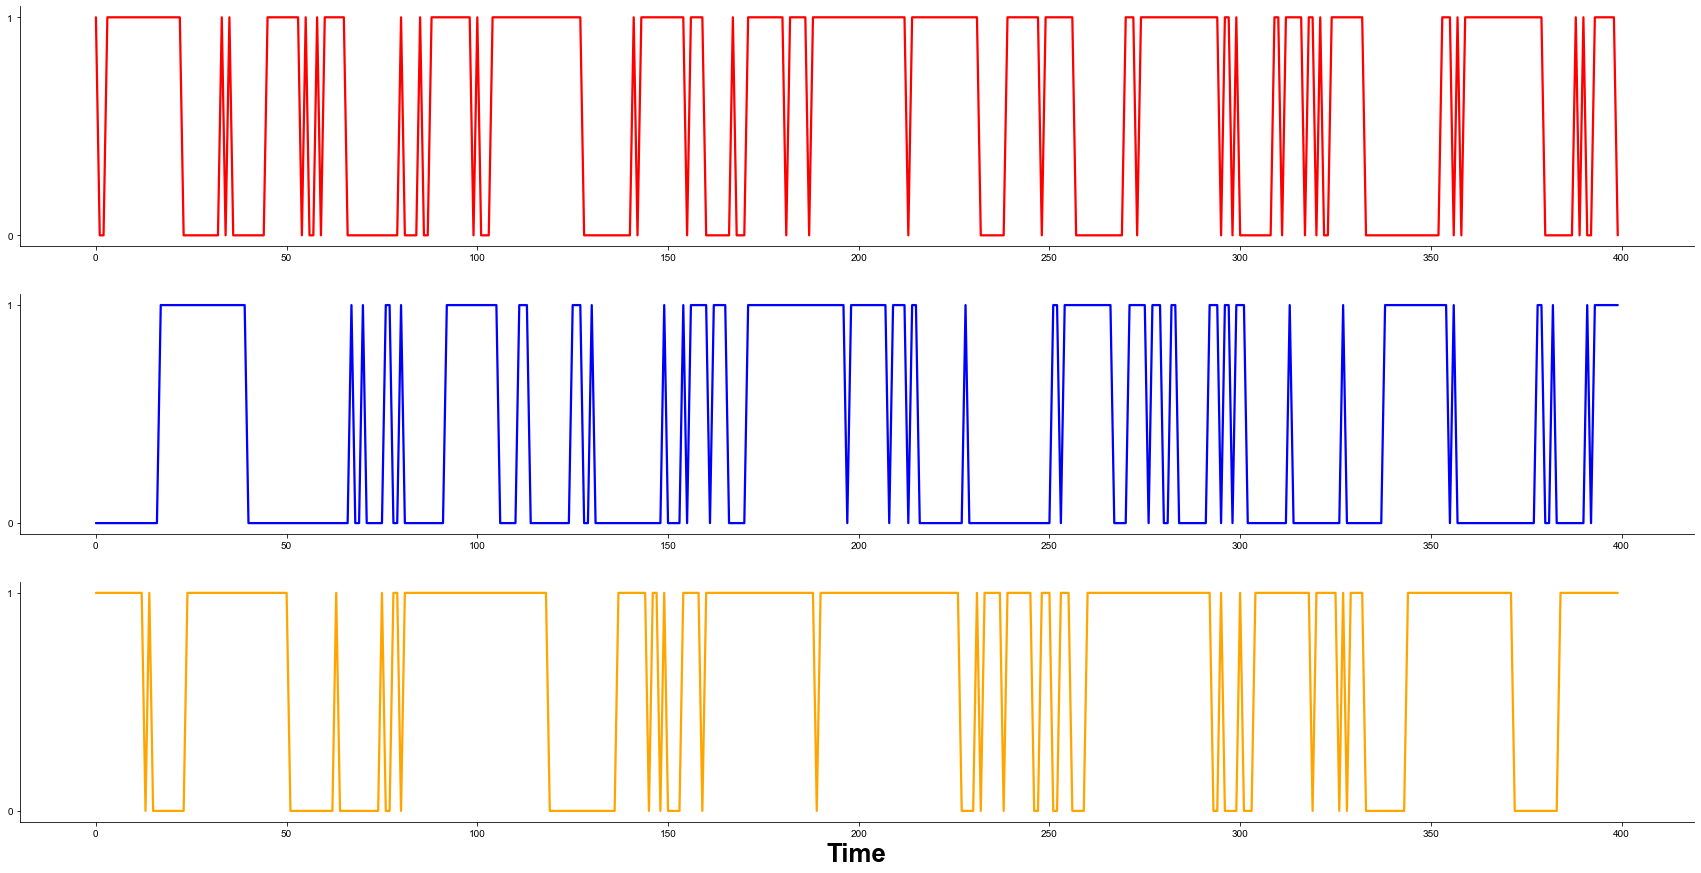

In [8]:
f,ax=plt.subplots(3,1,figsize=(30,15))

sns.set_context('talk')
sns.set_style('white')
ax[0].plot(test_data[4,0,500:], c='red')
ax[1].plot(test_data[4,1,500:], c='blue')
ax[2].plot(test_data[4,2,500:], c='orange')

for i in [0,1,2]:
    ax[i].set_yticks([0,1])
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    
ax[2].set_xlabel('Time', fontsize='x-large', fontweight='bold')

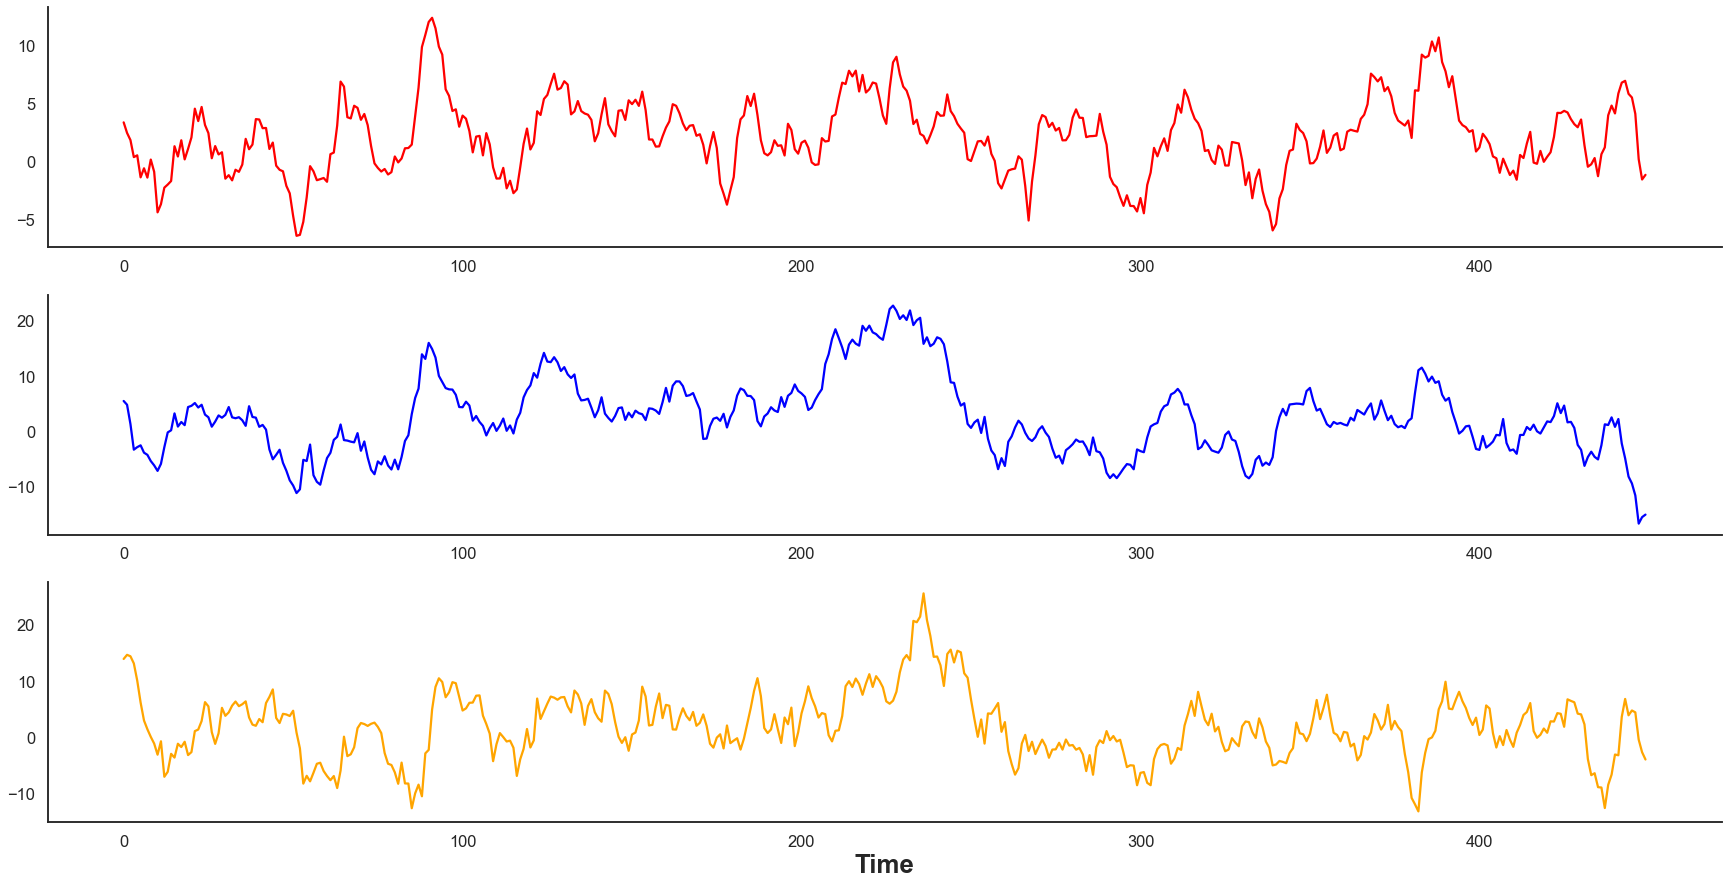

In [8]:
f,ax=plt.subplots(3,1,figsize=(30,15))

sns.set_context('talk')
sns.set_style('white')
ax[0].plot(z_data[4,0,int(T/2):], c='red')
ax[1].plot(z_data[4,1,int(T/2):], c='blue')
ax[2].plot(z_data[4,2,int(T/2):], c='orange')

ax[2].set_xlabel('Time', fontsize='x-large', fontweight='bold')

for i in [0,1,2]:
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)


<AxesSubplot:>

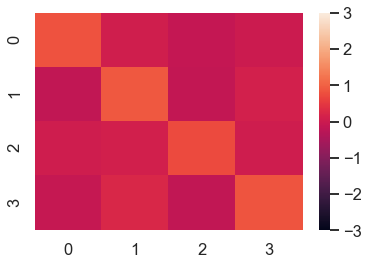

In [9]:
sns.heatmap(B,vmax=3,vmin=-3)

<AxesSubplot:>

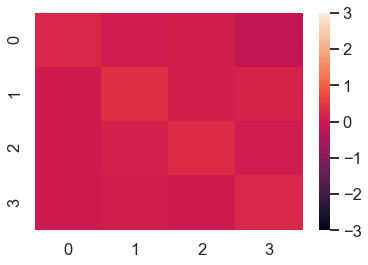

In [9]:
sns.heatmap(A,vmax=3,vmin=-3)

## Mean field approximation 

### Utils functions for mu gradient

In [10]:
def approx_mu_grad(var): 
    """
    Computes the full sum term in the mu gradient of the ELBO via MCMC approximation.
    """

    mu = var[0:d]
    sigmas = var[d:]
        
    epsilon = 1e-3
    
    #draw = np.random.randn(m,len(mu))
    transformed_draw = draw*sigmas + mu
    approx_1 = stats.norm.pdf(transformed_draw)/(np.maximum(stats.norm.cdf(transformed_draw),epsilon))
    approx_2 = stats.norm.pdf(transformed_draw)/np.maximum((1-stats.norm.cdf(transformed_draw)),epsilon)
    approx_1 = approx_1.mean(axis=0)
    approx_2 = approx_2.mean(axis=0)
    data_1 = np.multiply(data.sum(axis=2),approx_1).sum(axis=0)
    data_2 = np.multiply((1-data).sum(axis=2),approx_2).sum(axis=0)
    full_data = data_1 + data_2
    
    return full_data

In [11]:
def elbo_mu_grad(var):
    
    """
    Computes the gradient of the ELBO w.r.t. sigma. Returns a (d,) array. 
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    
    quadratic_term = (-T*N*mu.T@((np.identity(d)-B).T)@sigma_inv@(np.identity(d)-B)).reshape(d,1)
        
    time_sum = (-np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)).T@sigma_inv@(B-np.identity(d))).reshape(d,1)
        
    exp_sum = approx_mu_grad(var).reshape(d,1)
    
    return quadratic_term + time_sum + exp_sum

### Utils functions for sigma gradient

In [12]:
def approx_sigma_grad(var): 
    
    """
    Computes the full sum term in the mu gradient of the ELBO via MCMC approximation. 
    """
    
    d = data.shape[1]

    mu = var[0:d]
    sigmas = var[d:]
    T = data.shape[2]
    
    epsilon = 1e-3
        
    #draw = np.random.randn(m,len(mu))
    transformed_draw = draw*sigmas + mu
    approx_1 = draw*stats.norm.pdf(transformed_draw)/(np.maximum(stats.norm.cdf(transformed_draw),epsilon))
    approx_2 = draw*stats.norm.pdf(transformed_draw)/(np.maximum(1-stats.norm.cdf(transformed_draw),epsilon))
    approx_1 = approx_1.mean(axis=0)
    approx_2 = approx_2.mean(axis=0)
    data_1 = np.multiply(data.sum(axis=2),approx_1).sum(axis=0)
    data_2 = np.multiply((1-data).sum(axis=2),approx_2).sum(axis=0)
    full_data = data_1 - data_2
    
    return full_data

In [13]:
def elbo_sigma_grad(var): 
    
    """
    Computes the gradient of the ELBO w.r.t. sigma. Returns a (d,) array. 
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    
    diag_term = -(T*N*np.diag(sigma_inv+B.T@sigma_inv@B)*sigmas).reshape(d,1)
    entropy_term = -((T*N)/sigmas).reshape(d,1)
    exp_sum = approx_sigma_grad(var).reshape(d,1)
    
    return diag_term + entropy_term + exp_sum

### Other utils

In [26]:
def compute_expectation(var): 
    
    """
    Approximates the full sum term in the ELBO. Returns a scalar.
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    epsilon = 1e-3
    
    
    #draw = np.random.randn(m,len(mu))
    transformed_draw = draw*sigmas + mu
    approx_1 = np.log(np.maximum(stats.norm.cdf(transformed_draw),epsilon))
    approx_2 = np.log(np.maximum(1-stats.norm.cdf(transformed_draw),epsilon))
    approx_1 = approx_1.mean(axis=0)
    approx_2 = approx_2.mean(axis=0)
    data_1 = np.multiply(data.sum(axis=2),approx_1).sum(axis=0)
    data_2 = np.multiply((1-data).sum(axis=2),approx_2).sum(axis=0)
    full_data = data_1 + data_2
    return full_data.sum()
    

In [27]:
def elbo(var):
    
    """
    Computes the ELBO(evidence lower bound) of the model. Returns -ELBO, a scalar, in order to cast the maximization
    problem as a minimization problem.
    """
    
    mu = var[0:d]
    sigmas = var[d:]
    
    entropy_term = -(T*N/2)*(d*np.log(2*math.pi)+d*np.log(2*math.pi*math.e)+np.linalg.slogdet(sigma)[1]+2*np.log(sigmas).sum())
    
    expectation_term = compute_expectation(var)
    
    bilinear_term = -(T*N/2)*mu.T@(sigma_inv - 2*sigma_inv@B + B.T@sigma_inv@B)@mu
    
    norm_term = -1/2*(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0))).T@sigma_inv@(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)))
    
    time_sum = (-(np.matmul(A,data[:,:,:-1]).sum(axis=(2,0)).T)@sigma_inv@(B-np.identity(d)))@mu
    
    diag_term = -T*N/2*(np.diag(sigma_inv+B.T@sigma_inv@B)*(sigmas**2)).sum()
    
    elbo_value = -float((entropy_term + expectation_term + diag_term + time_sum + norm_term))
        
    return 1/N*elbo_value

In [16]:
def full_jacobian(var): 
    
    """
    Util function that returns minus the full jacobian of the ELBO (needed for scipy.optimize). 
    """
    
    mu_grad = elbo_mu_grad(var)
    sigma_grad = elbo_sigma_grad(var)
    
    full_grad = np.array([mu_grad,sigma_grad]).reshape((2*d,))
    
    return -1/N*full_grad

### Optimization with SCIPY.OPTIMIZE

In [17]:
import scipy.optimize as optim
import scipy.stats as stats

In [18]:
d = 3
N=100
T= 50

In [19]:
A,B,sigma,data,latent_state = sample(i=N,T=T,d=d)

In [20]:
sigma_inv = np.linalg.inv(sigma)

In [21]:
draw = np.random.randn(400,d)

In [22]:
scipy.optimize.minimize(elbo,x0 = 6*np.ones(2*d),jac=full_jacobian, method='bfgs',bounds=[None,None,None,0,0,0])


/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method bfgs cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


      fun: nan
 hess_inv: array([[ 9.71446222e-01,  1.53128070e-01,  4.08090416e-02,
         4.99715563e-04, -9.43275573e-04, -1.23042006e-03],
       [ 1.53128070e-01,  8.74177373e-02, -2.28707844e-01,
        -3.40189312e-05, -3.06201802e-04, -3.25375768e-04],
       [ 4.08090416e-02, -2.28707844e-01,  9.40639910e-01,
         4.62805869e-04,  5.76172403e-04,  4.63898422e-04],
       [ 4.99715563e-04, -3.40189312e-05,  4.62805869e-04,
         3.78457021e-04, -4.19953379e-09, -3.34747537e-07],
       [-9.43275573e-04, -3.06201802e-04,  5.76172403e-04,
        -4.19953380e-09,  2.17660262e-04,  1.75907385e-06],
       [-1.23042006e-03, -3.25375768e-04,  4.63898422e-04,
        -3.34747537e-07,  1.75907385e-06,  2.83650990e-04]])
      jac: array([ 5.81365149e+01,  8.87068798e+01,  2.02971378e+01,  4.13849015e+04,
       -9.91705983e+02, -9.04021991e+02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 20
      nit: 6
     njev: 20
   status: 2
  

In [23]:
draw = np.random.randn(1000,d)
normalize=1/(T*d*N)
print(normalize*scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 0.9*np.ones(2*d)))
print(normalize*scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 1*np.ones(2*d)))
print(normalize*scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 2*np.ones(2*d)))
print(normalize*scipy.optimize.check_grad(elbo,grad=full_jacobian, x0= 3*np.ones(2*d)))

0.011099941300931714
0.01251763387964204
0.029430549004852074
0.04778571572900209


### CA optimization 

The cell bellow performs coordinate-wise optimization.

In [24]:
#Max iterations of coordinate descent and max iterations for every gradient descent within coordinate descent
max_it = 40
max_it_gd = 1000


#Initialization
variables = 4*np.ones(2*d) 

#Matrices to save values

variables_track = np.zeros((2*d,max_it*max_it_gd))

elbo_track = np.zeros(max_it)

for iteration in np.arange(max_it):
    
    optimization_order = np.random.permutation(np.arange(2*d))
    
    for i in optimization_order:
        
        for it in np.arange(max_it_gd):
            
            draw = np.random.randn(400,d)
            
            grad_noise = np.sqrt(0.0001/((iteration*max_it_gd + it + 1)**(0.55)))*np.random.randn(1)
            
            if i in np.arange(d,2*d):
                
                #This loop is for optimization of the variance parameters. 
                
                lr=0.00001/(iteration*max_it_gd + it + 1)
                
                #Gradient (as well as ELBO) is normalized by the number of individuals.
                
                grad = (-1/N)*elbo_sigma_grad(variables)[i-d]
                
                variables[i] = np.maximum(variables[i] - lr*grad + grad_noise,1e-18)
                
                
            else: 
                
                #This loop is for optimization of the mean parameters. 
                
                lr=0.001
                
                grad = (-1/N)*elbo_mu_grad(variables)[i]
                
                variables[i] = variables[i] - lr*grad + grad_noise
        
            variables_track[i,iteration*max_it_gd+it] = variables[i]
    
    elbo_track[iteration] = elbo(variables) 
    
    if iteration%2 ==0:
        
        print('Iteration ', iteration, ' completed.')
        print('ELBO value:', elbo_track[iteration])
        print('Current parameters values:', variables)
        
        

Iteration  0  completed.
ELBO value: 184908.7546555572
Current parameters values: [ 5.65352521 -0.6666065   4.34360037  3.2743605   2.79721575  3.03350073]
Iteration  2  completed.
ELBO value: 182472.9886492177
Current parameters values: [ 6.18816832 -0.47657685  4.47062596  3.25948842  2.68283418  2.95176638]
Iteration  4  completed.
ELBO value: 180557.33203966758
Current parameters values: [ 6.47450322 -0.37765311  4.58511677  3.23987627  2.6292166   2.84475076]
Iteration  6  completed.
ELBO value: 180129.16732420816
Current parameters values: [ 6.6475524  -0.3248537   4.48389952  3.25524684  2.5821002   2.84617348]
Iteration  8  completed.
ELBO value: 180721.66911518422
Current parameters values: [ 6.7511961  -0.29320174  4.44789494  3.32150432  2.59121944  2.83740747]
Iteration  10  completed.
ELBO value: 180393.91697987204
Current parameters values: [ 6.83472269 -0.26382727  4.44759118  3.32768819  2.586724    2.80419559]
Iteration  12  completed.
ELBO value: 179136.1115901278
Cur

In [28]:
print(variables)

[ 6.87802514 -0.22702412  4.36265867  3.2489349   2.54947546  2.45162378]


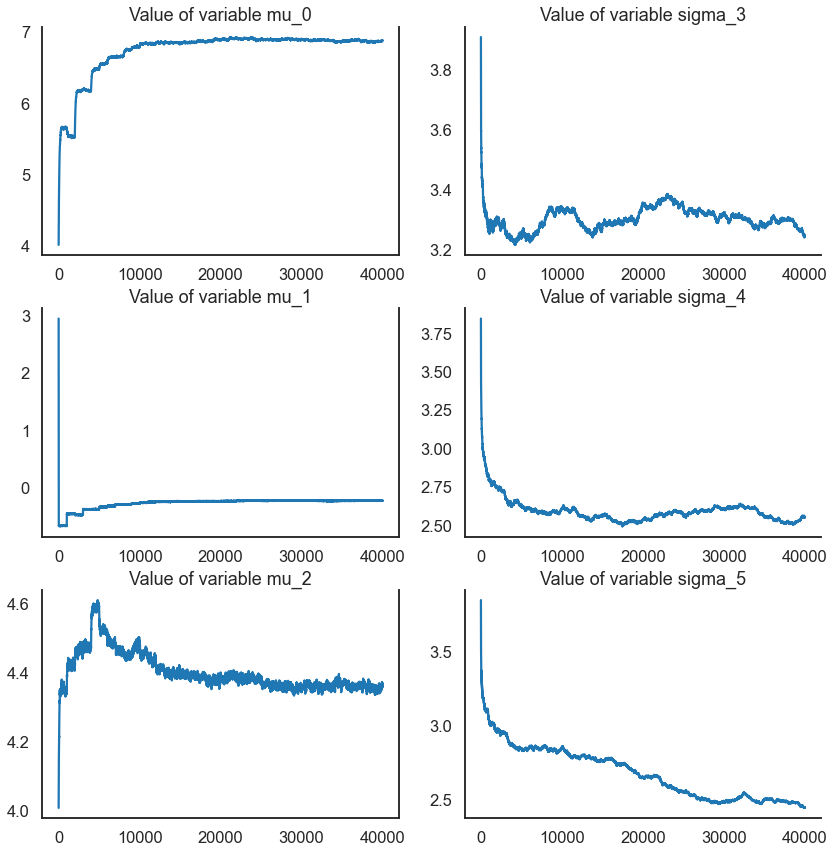

In [29]:
f,ax = plt.subplots(d,2,figsize=(12,12))
f.tight_layout()

for i in np.arange(2*d):
    
    sns.set_style('whitegrid')
    
    if i < d:
        ax[i,0].plot(variables_track[i,:], label='Value')
        ax[i,0].set_title('Value of variable mu_{}'.format(i))
        ax[i,0].spines["top"].set_visible(False)
        ax[i,0].spines["top"].set_visible(False)
    else:
        ax[i-d,1].plot(variables_track[i,:], label='Value')
        ax[i-d,1].set_title('Value of variable sigma_{}'.format(i))
        ax[i-d,1].spines["right"].set_visible(False)
        ax[i-d,1].spines["top"].set_visible(False)

[184908.75465556 183857.86928244 182472.98864922 180698.59448682
 180557.33203967 180263.08109311 180129.16732421 180674.21568259
 180721.66911518 181132.56549135 180393.91697987 179750.63268655
 179136.11159013 179126.8834142  179268.27137188 179302.23697329
 178736.11126512 178537.20682758 178227.6290202  178504.20993941
 178369.88903167 178950.83298729 178680.0724616  178567.84047662
 177867.26441632 177769.56533621 177638.55676386 177541.74056088
 177611.96616151 177568.04222781 177634.42113541 178102.84682928
 177866.97141474 177208.19360059 176735.94083491 176865.91548543
 176443.55288251 176294.09486056 176161.92009012 175971.88800305]


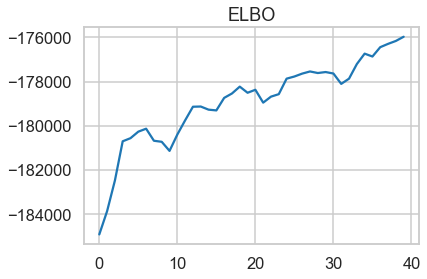

In [30]:
plt.plot(-elbo_track)
plt.title('ELBO')

print(elbo_track)

### Vanilla GD

The cell bellow performs vanilla gradient descent for maximization of the ELBO. 

In [31]:
#Max iterations of coordinate descent and max iterations for every gradient descent within coordinate descent

max_it_gd = 4000
lr=0.000001

#Initialization
variables = 4*np.ones(2*d) 

#Matrices to save values

variables_track = np.zeros((2*d,max_it_gd))

elbo_track = np.zeros(max_it_gd)

for it in np.arange(max_it_gd):

    draw = np.random.randn(400,d)

    grad_noise = np.sqrt(0.00001/((it + 1)**(0.55)))*np.random.randn(1)
    
    gradient = full_jacobian(variables)
    
    variables = variables - lr*gradient + grad_noise


    variables_track[:,it] = variables
    elbo_track[it] = elbo(variables) 

    if it%100 ==0:

        print('Iteration ', it, ' completed.')
        print('ELBO value:', elbo_track[it])
        print('Current parameters values:', variables)

Iteration  0  completed.
ELBO value: 222826.5486411749
Current parameters values: [3.999332   3.9980718  3.99888176 3.98854533 3.98059384 3.98492242]
Iteration  100  completed.
ELBO value: 177969.55721385745
Current parameters values: [4.03855695 3.91254558 3.99361223 3.07561308 2.51497911 2.80644184]
Iteration  200  completed.
ELBO value: 156842.51017024743
Current parameters values: [4.06211    3.81443234 3.97385559 2.36235468 1.58271838 1.96883968]
Iteration  300  completed.
ELBO value: 146878.6918457553
Current parameters values: [4.09221944 3.72592053 3.96176845 1.82186665 1.00272121 1.38846208]
Iteration  400  completed.
ELBO value: 141949.8907725579
Current parameters values: [4.12024347 3.63808973 3.94850937 1.40551318 0.63542251 0.97979396]
Iteration  500  completed.
ELBO value: 139407.30581061734
Current parameters values: [4.14310152 3.54798465 3.93090654 1.08178265 0.39860188 0.68864575]
Iteration  600  completed.
ELBO value: 138012.31246136024
Current parameters values: [4

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


Iteration  900  completed.
ELBO value: nan
Current parameters values: [ 4.21235294  3.19791588  3.84638187  0.3582681  -0.53765955  0.12618392]
Iteration  1000  completed.
ELBO value: nan
Current parameters values: [ 4.22538017  3.11466248  3.82332297  0.25977239 -0.33097974  0.02557718]
Iteration  1100  completed.
ELBO value: nan
Current parameters values: [ 4.24199045  3.03861167  3.805387    0.1813497  -0.19159477 -0.33074654]
Iteration  1200  completed.
ELBO value: nan
Current parameters values: [ 4.26238241  2.96981741  3.79186114  0.11503974 -0.0833105  -0.21075862]
Iteration  1300  completed.
ELBO value: nan
Current parameters values: [ 4.27292045  2.89364209  3.76903811  0.00748108 -0.13308349 -0.12401169]
Iteration  1400  completed.
ELBO value: nan
Current parameters values: [ 4.28105792  2.81690439  3.74429314  0.42465698 -0.03266781 -0.03295629]
Iteration  1500  completed.
ELBO value: nan
Current parameters values: [ 4.29312365  2.74619365  3.72445211  0.31376485 -0.13077375

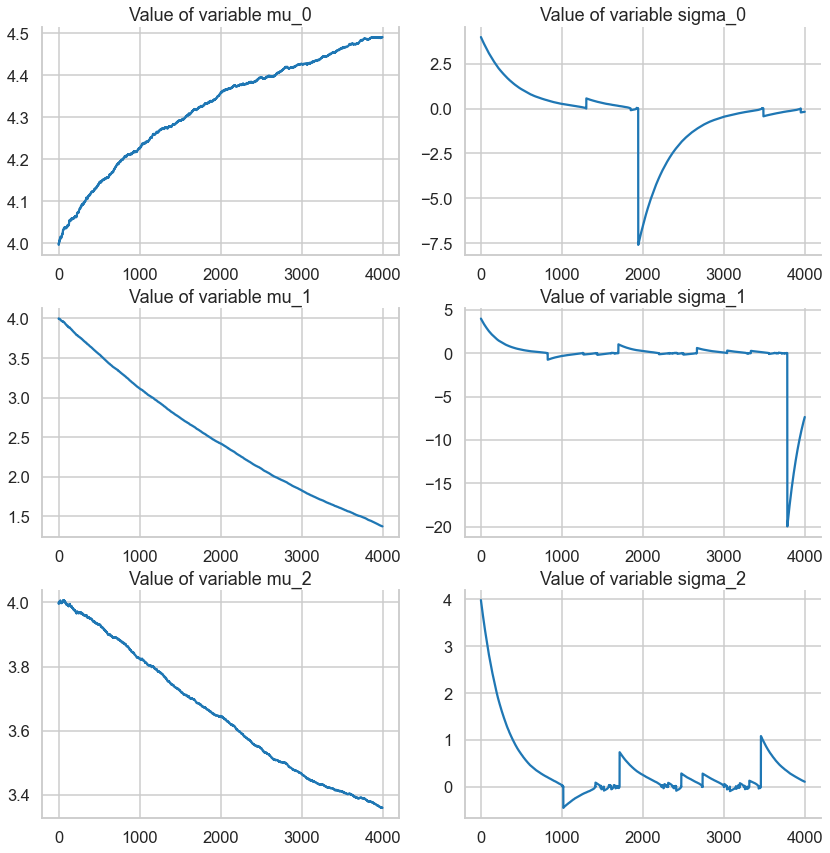

In [32]:
f,ax = plt.subplots(d,2,figsize=(12,12))
f.tight_layout()

for i in np.arange(2*d):
    
    sns.set_style('whitegrid')
    
    if i < d:
        ax[i,0].plot(variables_track[i,:], label='Value')
        ax[i,0].set_title('Value of variable mu_{}'.format(i))
        ax[i,0].spines["top"].set_visible(False)
        ax[i,0].spines["top"].set_visible(False)
    else:
        ax[i-d,1].plot(variables_track[i,:], label='Value')
        ax[i-d,1].set_title('Value of variable sigma_{}'.format(i-3))
        ax[i-d,1].spines["right"].set_visible(False)
        ax[i-d,1].spines["top"].set_visible(False)



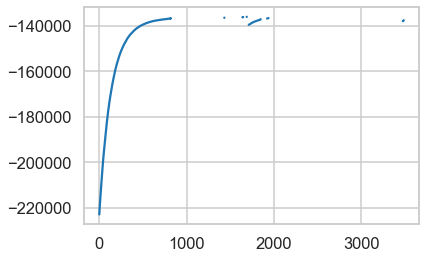

In [33]:
plt.plot(-elbo_track)